In [1]:
import pandas as pd
import bioframe as bf
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_rows', 100) 

In [14]:
ATAC_ENH_FILENAME = '/oak/stanford/groups/engreitz/Users/atan5133/abc_run_comparisons/results_10_26_dev_atac_k562_hic/Neighborhoods/EnhancerList.txt'
DHS_ENH_FILENAME = '/oak/stanford/groups/engreitz/Users/atan5133/abc_run_comparisons/results_10_27_dev_old_peak_calling/Neighborhoods/EnhancerList.txt'
ATAC_PRED_FILENAME = '/oak/stanford/groups/engreitz/Users/atan5133/abc_run_comparisons/results_10_26_dev_atac_k562_hic/Predictions/EnhancerPredictionsAllPutative.tsv.gz'
DHS_PRED_FILENAME = '/oak/stanford/groups/engreitz/Users/atan5133/abc_run_comparisons/results_10_27_dev_old_peak_calling/Predictions/EnhancerPredictionsAllPutative.tsv.gz'
CRISPR_FILENAME = "/oak/stanford/groups/engreitz/Projects/Benchmarking/CRISPR_data/EPCrisprBenchmark_ensemble_data_GRCh38.tsv.gz"
GENE = 'MYC'

In [15]:
atac_enh_df = pd.read_csv(ATAC_ENH_FILENAME, sep='\t').rename(columns={"chr": "chrom"})
dhs_enh_df = pd.read_csv(DHS_ENH_FILENAME, sep='\t').rename(columns={"chr": "chrom"})
atac_pred_df = pd.read_csv(ATAC_PRED_FILENAME, sep='\t').rename(columns={"chr": "chrom"})
dhs_pred_df = pd.read_csv(DHS_PRED_FILENAME, sep='\t').rename(columns={"chr": "chrom"})
crispr_df = pd.read_csv(CRISPR_FILENAME, sep='\t').rename(columns={"chromStart": "start", "chromEnd": "end"})

In [16]:
atac_df = atac_enh_df.merge(
    atac_pred_df,
    how="inner",
    on=["chrom", "start", "end"]
)
dhs_df = dhs_enh_df.merge(
    dhs_pred_df,
    how="inner",
    on=["chrom", "start", "end"]
)

In [17]:
atac_crispr_df = bf.overlap(
    crispr_df,
    atac_df,
    how="left",
    return_index=True
)

In [18]:
dhs_crispr_df = bf.overlap(
    crispr_df,
    dhs_df,
    how="left",
    return_index=True
)

In [19]:
myc_atac_crispr = atac_crispr_df[atac_crispr_df['measuredGeneSymbol'] == GENE].reset_index(drop=True)
myc_dhs_crispr = dhs_crispr_df[dhs_crispr_df['measuredGeneSymbol'] == GENE].reset_index(drop=True)

In [20]:
def merge_multiple_predictions(overlap_df, agg_fn=np.max):
    score_cols = []
    for pattern in ["activity_base", "RPM", "RPKM", "Score", "hic_contact"]:
        score_cols += list(overlap_df.filter(regex=pattern).columns)
    name_col = "name"
    duplicated_names = overlap_df[overlap_df.duplicated(name_col)][name_col]
    new_df = overlap_df.drop_duplicates(subset=[name_col]).reset_index(drop=True)
    for name in duplicated_names:
        entries = overlap_df[overlap_df[name_col] == name]
        for score_col in score_cols:
            new_score = agg_fn(entries[score_col])
            new_entry = new_df[
                new_df[name_col] == name
            ].index  # Should only be 1 b/c we removed duplicates
            new_df.loc[new_entry, score_col] = new_score
    return new_df

In [21]:
myc_atac_crispr = merge_multiple_predictions(myc_atac_crispr)
myc_dhs_crispr = merge_multiple_predictions(myc_dhs_crispr)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


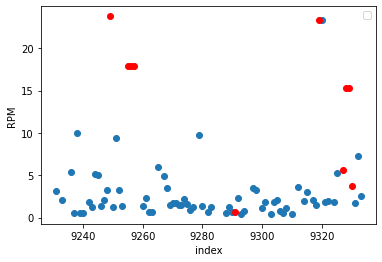

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


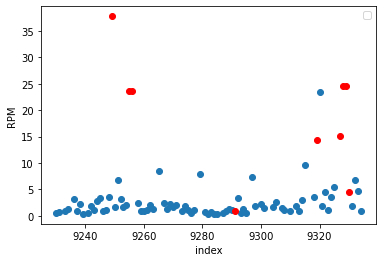

In [22]:
plt.clf()
for df in [myc_atac_crispr, myc_dhs_crispr]:
    X, Y = [], []
    put_X, put_Y = [], []
    for _, row in df.iterrows():
        activity = row['activity_base_x_']
        idx = row['index']
        if row['Significant']:
            put_X.append(idx)
            put_Y.append(activity)
        else:
            X.append(idx)
            Y.append(activity)

    plt.scatter(X,Y)
    plt.scatter(put_X,put_Y, color='red')
    plt.xlabel('index')
    plt.ylabel('RPM')
    plt.legend()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


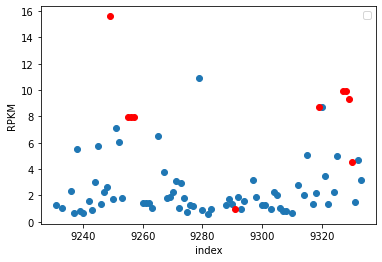

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


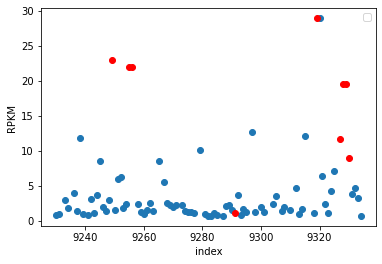

In [23]:
plt.clf()
for df in [myc_atac_crispr, myc_dhs_crispr]:
    X, Y = [], []
    put_X, put_Y = [], []
    for _, row in df.iterrows():
        activity = row['ATAC.RPKM_'] if 'ATAC.RPKM_' in row else row['DHS.RPKM_']
        idx = row['index']
        if row['Significant']:
            put_X.append(idx)
            put_Y.append(activity)
        else:
            X.append(idx)
            Y.append(activity)

    plt.scatter(X,Y)
    plt.scatter(put_X,put_Y, color='red')
    plt.xlabel('index')
    plt.ylabel('RPKM')
    plt.legend()
    plt.show()

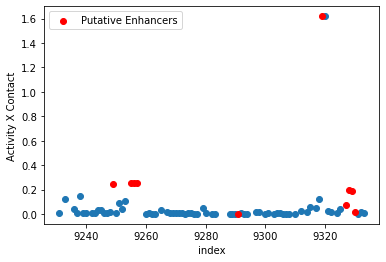

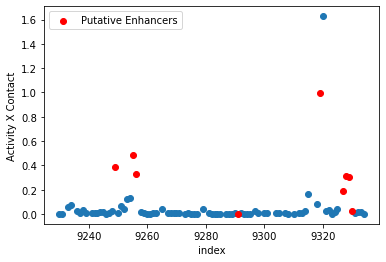

In [24]:
plt.clf()
for df in [myc_atac_crispr, myc_dhs_crispr]:
    X, Y = [], []
    put_X, put_Y = [], []
    for _, row in df.iterrows():
        activity = row['activity_base_x_']
        contact = row["hic_contact_"]
        idx = row['index']
        dhs_contact = myc_dhs_crispr[myc_dhs_crispr["index"]==idx].iloc[0]['hic_contact_']
        if row['Significant']:
            put_X.append(idx)
            put_Y.append(activity * contact)
        else:
            X.append(idx)
            Y.append(activity * contact)

    plt.scatter(X,Y)
    plt.scatter(put_X,put_Y, color='red', label="Putative Enhancers")
    plt.xlabel('index')
    plt.ylabel('Activity X Contact')
    plt.legend()
    plt.show()

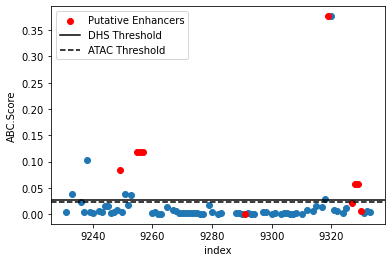

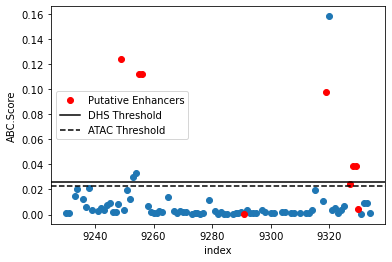

In [25]:
plt.clf()
for df in [myc_atac_crispr, myc_dhs_crispr]:
    X, Y = [], []
    put_X, put_Y = [], []
    for _, row in df.iterrows():
        activity = row['ABC.Score_']
        idx = row['index']
        if row['Significant']:
            put_X.append(idx)
            put_Y.append(activity)
        else:
            X.append(idx)
            Y.append(activity)

    plt.scatter(X,Y)
    plt.scatter(put_X,put_Y, color='red', label="Putative Enhancers")
    plt.xlabel('index')
    plt.ylabel('ABC.Score')
    plt.axhline(y=.026, color="black", linestyle="-", label=f"DHS Threshold")
    plt.axhline(y=.023, color="black", linestyle="--", label=f"ATAC Threshold")
    plt.legend()
    plt.show()